In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name, num_proc=4)
dataset = dataset["train"]

import os


# os.chdir("/code/img2img_turbo/src")
import argparse


import numpy as np


from PIL import Image
import torch


from torchvision import transforms


import torchvision.transforms.functional as F


from img2img_turbo.src.pix2pix_turbo import Pix2PixLight


from img2img_turbo.src.image_prep import canny_from_pil


from img2img_turbo.src.benchmark import merge_loras

model_name = ""


# model_path = "/code/img2img_turbo/models/model_20001.pkl"


model_path = "img2img_turbo/output/pix2pix_turbo/nfs_pix2pix_1736652315/checkpoints/model_7201.pkl"


use_fp16 = not False


# initialize the model


model = Pix2PixLight(dtype=torch.float16)


model.set_eval()


# if use_fp16:


# model.to(torch.bfloat16)


# model.unet.to(torch.bfloat16)


# model.vae.to(torch.bfloat16)


T = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(512),
    ]
)

/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `to

In [ ]:
model.unet = model.unet.from_pretrained(
    "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1739912522/checkpoints/model_15001/unet"
)
model.vae = model.vae.from_pretrained(
    "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1739912522/checkpoints/model_15001/vae"
)
model.unet = model.unet.to(model.sched.betas.dtype).cuda()
model.vae = model.vae.to(model.sched.betas.dtype).cuda()

The config attributes {'block_out_channels': [64, 64, 64, 64], 'shift_factor': 0.0, 'upsample_fn': 'nearest'} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
# не работает для sd turbo
# from safetensors.torch import load_file
# from diffusers.loaders.lora_conversion_utils import (
#     _convert_non_diffusers_lora_to_diffusers,
# )


# state_dict = load_file("img2img_turbo/models/pytorch_lora_weights.safetensors")


# new_state_dict, network_alphas = _convert_non_diffusers_lora_to_diffusers(
#     state_dict, unet_name=""
# )

In [14]:
# new_state_dict[".down_blocks.0.attentions.0.proj_in.lora.down.weight"].shape

torch.Size([64, 320, 1, 1])

In [16]:
# for key in list(new_state_dict.keys()):
#     new_state_dict[key[1:]] = new_state_dict.pop(key)

In [3]:
# не работает из коробки
# from diffusers import AutoencoderTiny, StableDiffusionPipeline

# model.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd").to(
#     device="cuda",
#     dtype=torch.bfloat16,
# )

In [ ]:
# model.unet.load_lora_adapter(
#     new_state_dict, network_alphas=network_alphas, unet=model.unet, strict=False
# )
# model.unet.fuse_lora()

In [17]:
model.timesteps = torch.tensor([999], device="cuda:0")

In [37]:
model.sched.set_timesteps(1, "cuda")

In [40]:
# merge_loras(model=model)
# model.unet.to(torch.bfloat16)
# None

In [ ]:
# for item in model.named_parameters():
#     print(item[0])

In [13]:
from sfast.compilers.diffusion_pipeline_compiler import compile, CompilationConfig

config = CompilationConfig.Default()
# xformers and Triton are suggested for achieving best performance.
try:
    import xformers

    config.enable_xformers = True
except ImportError:
    print("xformers not installed, skip")
try:
    import triton

    config.enable_triton = True
except ImportError:
    print("Triton not installed, skip")
# CUDA Graph is suggested for small batch sizes and small resolutions to reduce CPU overhead.
# But it can increase the amount of GPU memory used.
# For StableVideoDiffusionPipeline it is not needed.
config.enable_cuda_graph = True

model = compile(model, config)

In [25]:
T = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
    ]
)

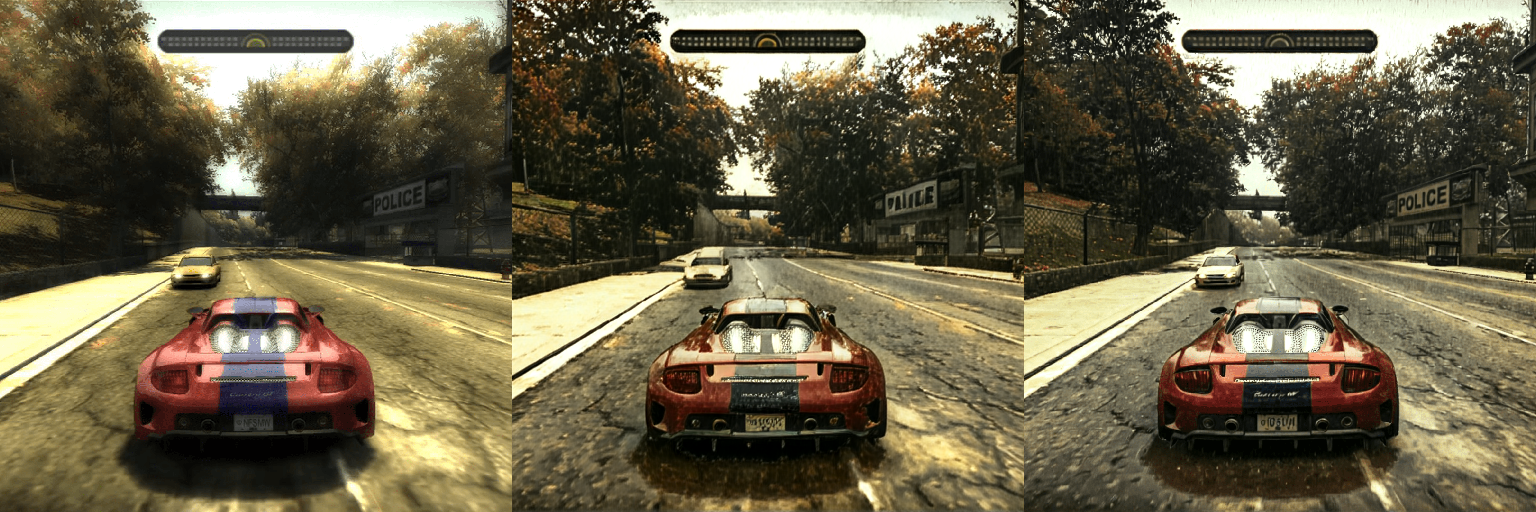

In [25]:
pos = 180
input_image = dataset[pos]["input_image"].convert("RGB")
prompt = dataset[0]["edit_prompt"]
target_image = T(dataset[pos]["edited_image"].convert("RGB"))

with torch.no_grad():
    i_t = T(input_image)
    # i_t = T(
    #     torch.tensor(
    #         np.asarray(input_image),
    #         device="cuda",
    #         dtype=torch.float32,
    #     ).permute(2, 0, 1)
    # )
    # i_t = input_image
    c_t = F.to_tensor(i_t).unsqueeze(0)
    # if use_fp16:
    # c_t = c_t.to(torch.bfloat16).cuda()
    c_t = c_t.cuda().to(torch.float16)
    # c_t = i_t.unsqueeze(0)
    # output_image = model(c_t, prompt)
    # output_image = model.custom_forward(c_t, prompt)
    output_image = model(c_t)

    output_pil = transforms.ToPILImage()(output_image[0].cpu() * 0.5 + 0.5)
    dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
    dst.paste(T(input_image), (0, 0))
    dst.paste(output_pil, (output_pil.width, 0))
    dst.paste(target_image, (output_pil.width * 2, 0))

dst

In [13]:
T(
    torch.tensor(
        np.asarray(input_image),
        device="cuda",
        dtype=torch.float16,
    ).permute(2, 0, 1)
).dtype

torch.float16

In [11]:
F.to_tensor(T(input_image)).dtype

torch.float32

### Save to Folder

In [ ]:
import os
from tqdm import tqdm

start_pos = 170
end_pos = 570
save_folder = "comfyui_sandbox/video_renders/render_img2img_light_1"
os.system(f"mkdir -p {save_folder}")

with torch.no_grad():
    for pos in tqdm(range(start_pos, end_pos)):
        input_image = dataset[pos]["input_image"].convert("RGB")
        prompt = dataset[0]["edit_prompt"]
        target_image = T(dataset[pos]["edited_image"].convert("RGB"))

        i_t = T(input_image)
        # i_t = input_image
        c_t = F.to_tensor(i_t).unsqueeze(0)
        # if use_fp16:
        # c_t = c_t.to(torch.bfloat16).cuda()
        c_t = c_t.cuda().to(torch.float16)
        # output_image = model(c_t, prompt)
        # output_image = model.custom_forward(c_t, prompt)
        output_image = model(c_t)

        output_pil = transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).cpu())
        dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
        dst.paste(i_t, (0, 0))
        dst.paste(output_pil, (output_pil.width, 0))
        dst.paste(target_image, (output_pil.width * 2, 0))

        dst.save(f"{save_folder}/{pos}.png")
# 02:35 orig
# 02:25 optimized
# 01:17 optimized light

100%|██████████| 400/400 [01:17<00:00,  5.16it/s]


In [28]:
77/400


0.1925

In [36]:
from tqdm import tqdm

start_pos = 170
end_pos = 570
images = [
    F.to_tensor(T(dataset[pos]["input_image"].convert("RGB"))).unsqueeze(0).cuda()
    for pos in tqdm(range(start_pos, end_pos))
]

100%|██████████| 400/400 [00:15<00:00, 26.26it/s]


In [40]:
import time

amount = 100
start = time.time()
for image in images[:amount]:
    # image = image.cuda()
    # output_image = model(c_t, prompt)
    # output_image = model.custom_forward(c_t, prompt)
    output_image = model.forward(image, prompt)
total = time.time() - start
print(f"total {total}, {total/amount}s per img")

total 11.230732202529907, 0.11230732202529907s per img


In [ ]:
model

In [ ]:
# huggingface-cli upload nfs_pix2pix_1739912522 /code/img2img_turbo/output/pix2pix_light/nfs_pix2pix_1739912522/checkpoints/model_15001 model_15001